In [525]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [526]:
housing = pd.read_csv('./Housing.csv')
vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']
data = housing[vars]
data.head()

,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


In [527]:
# Scaled the dataset using standardization scaling. 
scaled = StandardScaler()
scaled_data_raw = scaled.fit_transform(data.values[:,:])
scaled_data = pd.DataFrame(scaled_data_raw)
scaled_data

,0,1,2,3,4,5
0,1.046726,1.403419,1.421812,1.378217,1.517692,4.566365
1,1.757010,1.403419,5.405809,2.532024,2.679409,4.004484
2,2.218232,0.047278,1.421812,0.224410,1.517692,4.004484
3,1.083624,1.403419,1.421812,0.224410,2.679409,3.985755
4,1.046726,1.403419,-0.570187,0.224410,1.517692,3.554979
...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,-0.929397,1.517692,-1.576868
541,-1.268613,0.047278,-0.570187,-0.929397,-0.805741,-1.605149
542,-0.705921,-1.308863,-0.570187,-0.929397,-0.805741,-1.614327
543,-1.033389,0.047278,-0.570187,-0.929397,-0.805741,-1.614327


In [528]:
X_data = torch.tensor(scaled_data.values[:,0:5], dtype=torch.float32)
Y_data = torch.tensor(scaled_data.values[:,5], dtype=torch.float32)

In [529]:
# Splitting the dataset using training and validation split in Textbook
n_samples = X_data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# Commented for testing.
#train_indices, val_indices

X_train = X_data[train_indices]
Y_train_raw = Y_data[train_indices]
Y_train = torch.reshape(Y_train_raw, (436,1))

X_val = X_data[val_indices]
Y_val_raw = Y_data[val_indices]
Y_val = torch.reshape(Y_val_raw, (109,1))
print("X_train =", X_train[0:5])
print("Y_train =", Y_train[0:5])
print(X_train.size(), X_val.size(), Y_train.size(), Y_val.size())

X_train = tensor([[ 0.8530,  0.0473, -0.5702, -0.9294,  1.5177],
        [ 0.3918,  0.0473,  1.4218,  0.2244,  0.3560],
        [-0.9089,  0.0473,  1.4218,  0.2244,  1.5177],
        [-0.0740,  1.4034,  1.4218,  0.2244, -0.8057],
        [-0.1732,  1.4034, -0.5702,  0.2244, -0.8057]])
Y_train = tensor([[ 0.5545],
        [ 1.3824],
        [ 0.2399],
        [-0.1197],
        [-0.7715]])
torch.Size([436, 5]) torch.Size([109, 5]) torch.Size([436, 1]) torch.Size([109, 1])


In [530]:
def training_loop(n_epochs, optimizer, model, loss_fn, X_train, X_val, Y_train, Y_val, epochs, train_loss, val_loss):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(X_train) # <1>
        loss_train = loss_fn(t_p_train, Y_train)

        t_p_val = model(X_val) # <1>
        loss_val = loss_fn(t_p_val, Y_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        epochs.append(epoch)
        train_loss.append(loss_train.item())
        val_loss.append(loss_val.item())
        if epoch == 1 or epoch % 40 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [531]:
# Creating a neural network model with 1 hidden layer. Takes in 5 features (input variables) and out 8 values with bias. 
# Output takes 8 inputs and out one value with bias. Problem 3a
from collections import OrderedDict

seq_model_one = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(5, 8)),
    ('hidden_activation', nn.ReLU()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model_one

Sequential(
  (hidden_linear): Linear(in_features=5, out_features=8, bias=True)
  (hidden_activation): ReLU()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [532]:
for name, param in seq_model_one.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 5])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [533]:
# Creating the training loop of the model with one hidden layer. 
optimizer = optim.SGD(seq_model_one.parameters(), lr=0.07)

one_epochs = []
one_train_loss = []
one_val_loss = []

print("Training Linear Regressions's model with one hidden layer:")
params_one = training_loop(n_epochs = 200, optimizer = optimizer, model = seq_model_one, loss_fn = loss_fn, X_train = X_train, 
    X_val = X_val, Y_train = Y_train, Y_val = Y_val, epochs = one_epochs, train_loss = one_train_loss, val_loss = one_val_loss)
params_one

Training Linear Regressions's model with one hidden layer:
Epoch 1, Training loss 1.1061, Validation loss 1.0011
Epoch 40, Training loss 0.4766, Validation loss 0.4518
Epoch 80, Training loss 0.4474, Validation loss 0.4243
Epoch 120, Training loss 0.4356, Validation loss 0.4147
Epoch 160, Training loss 0.4288, Validation loss 0.4097
Epoch 200, Training loss 0.4240, Validation loss 0.4060


In [534]:
# Creating a neural network model with 3 hidden layers. Problem 3b
from collections import OrderedDict

seq_model_three = nn.Sequential(OrderedDict([
    ('hidden_linear_1', nn.Linear(5, 8)),
    ('hidden_activation_1', nn.ReLU()),
    ('hidden_linear_2', nn.Linear(8, 8)),
    ('hidden_activation_2', nn.ReLU()),
    ('hidden_linear_3', nn.Linear(8, 8)),
    ('hidden_activation_3', nn.ReLU()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model_three

Sequential(
  (hidden_linear_1): Linear(in_features=5, out_features=8, bias=True)
  (hidden_activation_1): ReLU()
  (hidden_linear_2): Linear(in_features=8, out_features=8, bias=True)
  (hidden_activation_2): ReLU()
  (hidden_linear_3): Linear(in_features=8, out_features=8, bias=True)
  (hidden_activation_3): ReLU()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [535]:
for name, param in seq_model_three.named_parameters():
    print(name, param.shape)

hidden_linear_1.weight torch.Size([8, 5])
hidden_linear_1.bias torch.Size([8])
hidden_linear_2.weight torch.Size([8, 8])
hidden_linear_2.bias torch.Size([8])
hidden_linear_3.weight torch.Size([8, 8])
hidden_linear_3.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [536]:
# Creating the training loop of the model with three hidden layers. 
optimizer = optim.SGD(seq_model_three.parameters(), lr=0.095)

three_epochs = []
three_train_loss = []
three_val_loss = []

print("Training Linear Regressions's model with three hidden layers:")
params_three = training_loop(n_epochs = 200, optimizer = optimizer, model = seq_model_three, loss_fn = loss_fn,
    X_train = X_train, X_val = X_val, Y_train = Y_train, Y_val = Y_val, epochs = three_epochs, train_loss = three_train_loss, 
    val_loss = three_val_loss)
params_three

Training Linear Regressions's model with three hidden layers:
Epoch 1, Training loss 1.2016, Validation loss 1.0893
Epoch 40, Training loss 0.5721, Validation loss 0.5873
Epoch 80, Training loss 0.4434, Validation loss 0.4287
Epoch 120, Training loss 0.4243, Validation loss 0.4191
Epoch 160, Training loss 0.4116, Validation loss 0.4109
Epoch 200, Training loss 0.4026, Validation loss 0.4057


<function matplotlib.pyplot.show(close=None, block=None)>

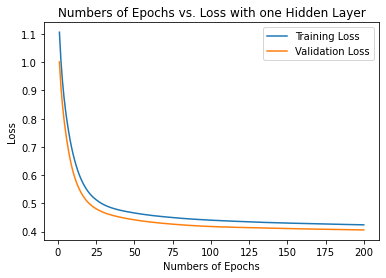

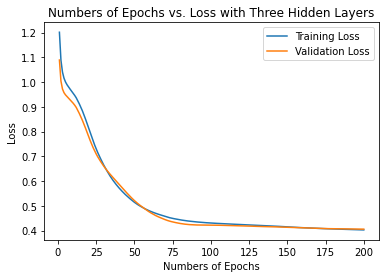

In [537]:
plt.figure(1)
plt.plot(one_epochs, one_train_loss, label = "Training Loss")
plt.plot(one_epochs, one_val_loss, label = "Validation Loss")
plt.xlabel("Numbers of Epochs")
plt.ylabel("Loss")
plt.title("Numbers of Epochs vs. Loss with one Hidden Layer")
plt.legend()
plt.show
plt.figure(2)
plt.plot(three_epochs, three_train_loss, label = "Training Loss")
plt.plot(three_epochs, three_val_loss, label = "Validation Loss")
plt.xlabel("Numbers of Epochs")
plt.ylabel("Loss")
plt.title("Numbers of Epochs vs. Loss with Three Hidden Layers")
plt.legend()
plt.show